## Histopathologic Cancer Detection

### Challenge Problem

This challenge involves identifying metastatic cancer in small image patches from digital pathology scans, a binary classification task where images are labeled as cancerous (1) or non-cancerous (0). The key challenges include handling .tif images, managing tissue appearance variability, addressing class imbalance, and ensuring proper feature extraction for accurate classification.

In [2]:
from PIL import Image
import tifffile as tiff
import numpy as np
import pandas as pd
import tifffile as tiff

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [70]:
# Load in the training labels
labels_df = pd.read_csv('train_labels.csv')

In [71]:
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [72]:
labels_df.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [73]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


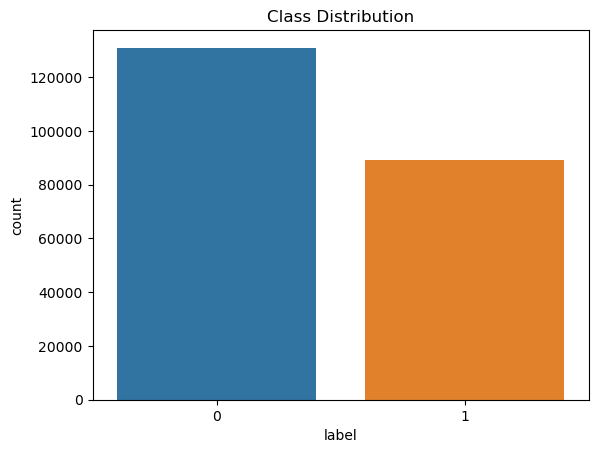

In [74]:
# Class distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=labels_df)
plt.title('Class Distribution')
plt.show()

In [75]:
# Percentage of each class
class_distribution = labels_df['label'].value_counts(normalize=True) * 100
print(class_distribution)

0    59.496875
1    40.503125
Name: label, dtype: float64


### Desciption of the Data

The dataset contains 220,025 unique image samples, each labeled as either 0 or 1, indicating a binary classification task. The class distribution shows that label 0 (the majority class) appears roughly 60% of the time (130,908 instances), while label 1 (the minority class) appears about 40% of the time (89,117 instances). Although the class imbalance is not extreme, it is significant enough to impact model evaluation.

While accuracy measures the overall correctness of the model, it can be misleading in the presence of class imbalance. Therefore, it is important to also consider precision and recall. Precision measures the correctness of positive predictions, ensuring a low false positive rate, while recall measures the model's ability to identify all relevant instances, ensuring a low false negative rate.

### EDA

The primary data cleaning task involves preparing the image files for use with the ImageDataGenerator and associated functions in TensorFlow. The only adjustment needed is appending ".tif" to the end of each label ID to correctly reference the image files during the data loading process. Another importamt mpte os that the dataset does not contain any missing values, so no imputation or removal of missing data is necessary.

As mentioned in the description of the data, there is a slight imbalance in the data. Before making any adjustments to the dataset to address class imbalance, we will evaluate the precision and recall of our models. This approach allows us to understand how well the model performs across different classes and whether the imbalance significantly impacts performance. 

The plan for this analysis is to utilize the ImageDataGenerator from TensorFlow.keras to load and preprocess the images, including rescaling pixel values and applying data augmentation techniques to enhance the training data. We will implement a Convolutional Neural Network (CNN) using TensorFlow.keras, starting with a simple model and iteratively refining it to improve performance.

In [ ]:
#add .tif to the end of every label ID
labels_df['label'] = labels_df['label'].astype(str)
labels_df['id'] = labels_df['id'].apply(lambda x: x + '.tif')

In [7]:
# Define ImageDataGenerator for training and validation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

In [8]:
# Create training and validation generators
train_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory='train',
    x_col='id',
    y_col='label',
    target_size=(32, 32),
    batch_size=512,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory='train',
    x_col='id',
    y_col='label',
    target_size=(32, 32),
    batch_size=512,
    class_mode='binary',
    subset='validation'
)

Found 154018 validated image filenames belonging to 2 classes.
Found 66007 validated image filenames belonging to 2 classes.


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.metrics import Precision, Recall

### Begininning Model Architecture

The model architecture consists of three convolutional layers with ReLU activation and increasing filter sizes (32, 64, 128), each followed by max-pooling layers to reduce spatial dimensions and computational complexity. These layers have the ability to learn spatial hierarchies of features. The use of ReLU activation introduces non-linearity, allowing the model to capture more complex patterns in the images.

After flattening the output from the convolutional layers, the model has a dense layer with 128 neurons and ReLU activation, followed by a single neuron with a sigmoid activation for binary classification. This combination allows the model to effectively combine and classify the features extracted from the images, outputting a probability score indicating the presence or absence of cancer. The chosen architecture effectively balances complexity and efficiency. This makes it suitable for the histopathologic cancer detection task.

In [34]:
# Define the first model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

In [35]:
# Compile the first model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

In [36]:
# Train the first model using the generators
history = model.fit(
    train_generator,
    epochs=6,
    validation_data=validation_generator
)

Epoch 1/6
301/301 [==============================] - 362s 1s/step - loss: 0.4895 - accuracy: 0.7675 - precision: 0.7372 - recall: 0.6624 - val_loss: 0.4596 - val_accuracy: 0.7903 - val_precision: 0.8043 - val_recall: 0.6363
Epoch 2/6
301/301 [==============================] - 368s 1s/step - loss: 0.4410 - accuracy: 0.7990 - precision: 0.7662 - recall: 0.7255 - val_loss: 0.4170 - val_accuracy: 0.8170 - val_precision: 0.7856 - val_recall: 0.7532
Epoch 3/6
301/301 [==============================] - 347s 1s/step - loss: 0.4081 - accuracy: 0.8172 - precision: 0.7977 - recall: 0.7355 - val_loss: 0.3967 - val_accuracy: 0.8255 - val_precision: 0.7675 - val_recall: 0.8157
Epoch 4/6
301/301 [==============================] - 400s 1s/step - loss: 0.3910 - accuracy: 0.8256 - precision: 0.8053 - recall: 0.7513 - val_loss: 0.3971 - val_accuracy: 0.8224 - val_precision: 0.7490 - val_recall: 0.8435
Epoch 5/6
301/301 [==============================] - 389s 1s/step - loss: 0.3743 - accuracy: 0.8346 - pr

In [37]:
# Calculate the validation loss and accuracy for the first model
val_loss, val_acc, val_precision, val_recall = model.evaluate(validation_generator)
print(f'Validation Accuracy: {val_acc:.2f}')
print(f'Validation Precision: {val_precision:.2f}')
print(f'Validation Recall: {val_recall:.2f}')

129/129 [==============================] - 95s 736ms/step - loss: 0.3526 - accuracy: 0.8461 - precision: 0.8316 - recall: 0.7768
Validation Accuracy: 0.85
Validation Precision: 0.83
Validation Recall: 0.78


### Second Model Iteration

In this second iteration of the model, we will incorporate batch normalization to protentially improve the accuracy, precision, and recall of the model. Batch normalization helps the model converge faster and more reliably to an optimal solution. This will ideally result in better generalization on unseen data, which could potenially enhance the model's ability to accurately classify images, leading to higher accuracy, precision, and recall.

In [38]:
# Define the model
model_2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

In [39]:
# Compile the model
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

In [40]:
# Train the model using the generators
history_2 = model_2.fit(
    train_generator,
    epochs=6,
    validation_data=validation_generator
)

Epoch 1/6
301/301 [==============================] - 553s 2s/step - loss: 0.4106 - accuracy: 0.8163 - precision_1: 0.7937 - recall_1: 0.7388 - val_loss: 1.0676 - val_accuracy: 0.5832 - val_precision_1: 0.4915 - val_recall_1: 0.8744
Epoch 2/6
301/301 [==============================] - 355s 1s/step - loss: 0.3429 - accuracy: 0.8506 - precision_1: 0.8321 - recall_1: 0.7911 - val_loss: 0.6553 - val_accuracy: 0.7247 - val_precision_1: 0.6029 - val_recall_1: 0.9355
Epoch 3/6
301/301 [==============================] - 351s 1s/step - loss: 0.3062 - accuracy: 0.8700 - precision_1: 0.8529 - recall_1: 0.8208 - val_loss: 0.5716 - val_accuracy: 0.8006 - val_precision_1: 0.7007 - val_recall_1: 0.8849
Epoch 4/6
301/301 [==============================] - 348s 1s/step - loss: 0.2838 - accuracy: 0.8809 - precision_1: 0.8656 - recall_1: 0.8361 - val_loss: 0.6684 - val_accuracy: 0.7424 - val_precision_1: 0.7964 - val_recall_1: 0.4878
Epoch 5/6
301/301 [==============================] - 350s 1s/step - loss

In [41]:
val_loss_2, val_acc_2, val_precision_2, val_recall_2 = model_2.evaluate(validation_generator)
print(f'Validation Accuracy: {val_acc_2:.2f}')
print(f'Validation Precision: {val_precision_2:.2f}')
print(f'Validation Recall: {val_recall_2:.2f}')

129/129 [==============================] - 89s 691ms/step - loss: 1.0271 - accuracy: 0.6890 - precision_1: 0.9328 - recall_1: 0.2491
Validation Accuracy: 0.69
Validation Precision: 0.93
Validation Recall: 0.25


### Third Model Iteration

In this third iteration we will replace the flatten and dense layers with global average pooling to reduce the number of parameters and prevent overfitting. Global average pooling condenses the spatial dimensions of the feature maps into a more compact representation. This change can enhance the model's generalization, hopefullly improving accuracy, precision, and recall. This approach emphasizes the most important features and reduces the potential of overfitting.

In [42]:
# Define the model
model_3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    GlobalAveragePooling2D(),  # Replaces Flatten and Dense layers
    Dense(1, activation='sigmoid')  # Binary classification
])

In [43]:
# Compile the model
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

In [44]:
# Train the model using the generators
history_3 = model_3.fit(
    train_generator,
    epochs=6,
    validation_data=validation_generator
)

Epoch 1/6
301/301 [==============================] - 364s 1s/step - loss: 0.4101 - accuracy: 0.8180 - precision_2: 0.7976 - recall_2: 0.7384 - val_loss: 0.6930 - val_accuracy: 0.6084 - val_precision_2: 0.5093 - val_recall_2: 0.8720
Epoch 2/6
301/301 [==============================] - 358s 1s/step - loss: 0.3573 - accuracy: 0.8438 - precision_2: 0.8308 - recall_2: 0.7717 - val_loss: 0.6928 - val_accuracy: 0.7448 - val_precision_2: 0.6364 - val_recall_2: 0.8609
Epoch 3/6
301/301 [==============================] - 362s 1s/step - loss: 0.3217 - accuracy: 0.8624 - precision_2: 0.8511 - recall_2: 0.8007 - val_loss: 0.6376 - val_accuracy: 0.7729 - val_precision_2: 0.6591 - val_recall_2: 0.9081
Epoch 4/6
301/301 [==============================] - 364s 1s/step - loss: 0.2991 - accuracy: 0.8727 - precision_2: 0.8629 - recall_2: 0.8154 - val_loss: 0.3919 - val_accuracy: 0.8341 - val_precision_2: 0.7532 - val_recall_2: 0.8773
Epoch 5/6
301/301 [==============================] - 365s 1s/step - loss

In [45]:
val_loss_3, val_acc_3, val_precision_3, val_recall_3 = model_3.evaluate(validation_generator)
print(f'Validation Accuracy: {val_acc_3:.2f}')
print(f'Validation Precision: {val_precision_3:.2f}')
print(f'Validation Recall: {val_recall_3:.2f}')

129/129 [==============================] - 94s 732ms/step - loss: 0.4951 - accuracy: 0.8132 - precision_2: 0.8464 - recall_2: 0.6576
Validation Accuracy: 0.81
Validation Precision: 0.85
Validation Recall: 0.66


### Results and Analysis

In [46]:
models = {
    "Model": ["Model 1", "Model 2", "Model 3"],
    "Precision": [val_precision, val_precision_2, val_precision_3],
    "Recall": [val_recall, val_recall_2, val_recall_3],
    "Accuracy": [val_acc, val_acc_2, val_acc_3]
}

In [47]:
# Create DataFrame
models_df = pd.DataFrame(models)

# Display the table
print(models_df)

     Model  Precision    Recall  Accuracy
0  Model 1   0.831576  0.776754  0.846077
1  Model 2   0.932810  0.249092  0.689033
2  Model 3   0.846391  0.657565  0.813232


<b>Why the Baseline Performed Well:</b> The baseline architecture (Model 1) demonstrated a well-balanced performance with precision, recall, and accuracy metrics of 0.831576, 0.776754, and 0.846077, respectively. This suggests that the model effectively identified true positives while maintaining a relatively low rate of false positives, making it suitable for applications where both precision and recall are critical.

<b>Improvements with Batch Normalization:</b> Introducing batch normalization (Model 2) significantly increased precision to 0.932810 but led to a marked decrease in recall and accuracy, with values of 0.249092 and 0.689033, respectively. This indicates that while the model was highly confident when predicting positive cases, it failed to identify a substantial number of true positives. The likely cause is overfitting or poor generalization to the validation data.

<b>Impact of Global Average Pooling:</b> Incorporating global average pooling in place of flatten and dense layers (Model 3) resulted in a more balanced performance with precision, recall, and accuracy metrics of 0.846391, 0.657565, and 0.813232, respectively. Although the precision and recall were slightly lower compared to Model 1, the reduction in overfitting and enhanced generalization provided a more consistent and reliable performance.

### Conclusion

This analysis showed that different architectures and techniques have varying impacts on model performance. The baseline model (Model 1) had the best balance between precision, recall, and accuracy, making it reliable for medical diagnostics. Model 2, with batch normalization, achieved high precision but very low recall and accuracy, indicating potential overfitting. Model 3, with global average pooling, provided a better trade-off between precision and recall while maintaining reasonable accuracy. These findings highlight the need to balance accuracy, precision, and recall based on application requirements. Further tuning, such as optimizing learning rates, experimenting with different optimizers, and employing more sophisticated augmentation techniques, could enhance performance. However, these efforts would require significant time and computational power.

### Procudeure to get the Test Labels

In [59]:
test_filenames = [file for file in os.listdir('test') if file.endswith('.tif')]
test_df = pd.DataFrame({'filename': test_filenames})

In [61]:
test_df.head()

,filename
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d.tif
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581.tif
2,19709bec800f372d0b1d085da6933dd3ef108846.tif
3,7a34fc34523063f13f0617f7518a0330f6187bd3.tif
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed.tif


In [62]:
# Create a test generator
test_datagen = ImageDataGenerator(rescale=1./255)

In [63]:
# Flow from DataFrame for test data
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='test',
    x_col='filename',
    y_col=None,  # No labels for test data
    target_size=(32, 32),
    batch_size=32,
    class_mode=None,  # No labels for test data
    shuffle=False  # Don't shuffle for test data
)

Found 57458 validated image filenames.


In [64]:
# Make predictions
predictions = model.predict(test_generator)
predicted_labels = (predictions > 0.5).astype(int).flatten()

In [66]:
predicted_labels

array([1, 1, 1, ..., 0, 0, 1])

In [67]:
# Prepare submission file
filenames = test_generator.filenames
test_ids = [os.path.splitext(os.path.basename(f))[0] for f in filenames]
submission_df = pd.DataFrame({'id': test_ids, 'label': predicted_labels})
submission_df.to_csv('submission.csv', index=False)